# Input Gradient based Interpreters Tutorials

Deep models are generally differentiable. Using input gradients is a natural thought of showing the importance of input features. However, deep models consist of numerous non-linear components, leading to gradient vanishing or explosion. Vanilla input gradients contain many noises and therefore lose some intuitions of showing the important features.

`InterpretDL` provides three algorithms based on input gradients that address this problem, i.e., [SmoothGrad](https://github.com/PaddlePaddle/InterpretDL/blob/master/interpretdl/interpreter/smooth_grad.py), [IntGrad](https://github.com/PaddlePaddle/InterpretDL/blob/master/interpretdl/interpreter/integrated_gradients.py), and [GradSHAP](https://github.com/PaddlePaddle/InterpretDL/blob/master/interpretdl/interpreter/gradient_shap.py). In fact, [GradSHAP](https://github.com/PaddlePaddle/InterpretDL/blob/master/interpretdl/interpreter/gradient_shap.py) is similar to [SmoothGrad](https://github.com/PaddlePaddle/InterpretDL/blob/master/interpretdl/interpreter/smooth_grad.py). So here in this tutorial, we introduce in details [SmoothGrad](https://github.com/PaddlePaddle/InterpretDL/blob/master/interpretdl/interpreter/smooth_grad.py) and [IntGrad](https://github.com/PaddlePaddle/InterpretDL/blob/master/interpretdl/interpreter/integrated_gradients.py).

We start by maths. We denote $G_c(x)$ as the gradient of the objective function w.r.t. the input $x$, where $c$ is the index of the ground-truth class. So we have the formulas of the two algorithms:

SmoothGrad

$$
\text{SG}_c(x) = \frac{1}{n}\sum_{1}^{n}G_c(x+\mathcal{N}(0,\,\sigma^{2})),
$$

where $\mathcal{N}(0,\,\sigma^{2})$ is the normal distribution that generates noises.

IntGrad

$$
\text{IG}_c(x) = (x - x') \int_{\alpha=0}^{1} G_c(x'+\alpha (x-x')) d\alpha,
$$

where $x'$ is the baseline that IntGrad considers the path starting point.


As we can see, the formulas are not very difficult to understand. 

The idea of `SmoothGrad` is to remove the noises that exist in vanilla gradients by adding noises on the input and then averaging the obtained gradients. The gradient backward may vanish at some layer. But when some noises are added on the input, the gradient may pass through all layers and get the intuitive parts in the input. More noise attempts can get more intuitive parts. The average operation can further reduce the irrelevant parts.

The idea of `IntGrad` is to use the data points interpolated between the baseline $x'$ and the input $x$, instead of using noised inputs.

Let's use `InterpretDL` and see the visualization results first.

In [6]:
import interpretdl as it
import paddle
device = 'gpu:2'
paddle.set_device(device)

print("Loading pretrained model.")
from paddle.vision.models import resnet50
paddle_model = resnet50(pretrained=True)

img_path = 'assets/fireboat.png'

Loading pretrained model.


Loading pretrained model.
SmoothGrad


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 24.19it/s]


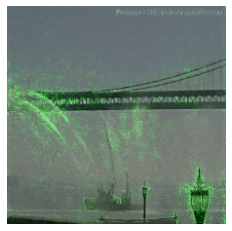

IntGrad


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 30.52it/s]


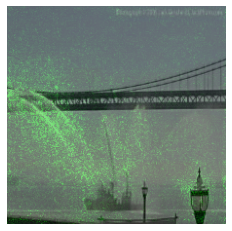

In [4]:
print("SmoothGrad")
algo = it.SmoothGradInterpreter(paddle_model, device=device)
gradients = algo.interpret(img_path, n_samples=100, labels=None)

print("IntGrad")
algo = it.IntGradCVInterpreter(paddle_model, device=device)
gradients = algo.interpret(img_path, baselines='random', num_random_trials=5, labels=None)

Let's go through all the details of these two Interpreters.

## Classifying Images

The process is the same as in [Getting Started Tutorial](https://github.com/PaddlePaddle/InterpretDL/blob/master/tutorials/Getting_Started.ipynb).

In [2]:
import interpretdl as it
import paddle
device = 'gpu:2'
paddle.set_device(device)

print("Loading pretrained model.")
from paddle.vision.models import resnet50
paddle_model = resnet50(pretrained=True)
paddle_model.eval()

img_path = 'assets/fireboat.png'
img, data = it.data_processor.readers.images_transform_pipeline(img_path)

!wget -c https://github.com/PaddlePaddle/InterpretDL/files/8561411/readable_label.txt -P ./assets/
f = open('assets/readable_label.txt', 'r')
lines = f.readlines()

# see the predicted top 5 probabilites
probability = paddle.nn.Softmax()(paddle_model(paddle.to_tensor(data)))
topvalues, top_ids = paddle.topk(probability, 5)

print('The model gives the predictions as follows:')
for cls_prob, cls_id in zip(topvalues[0].numpy(), top_ids[0].numpy()):
    print(f'\tprobability: {cls_prob:.5f} ({lines[cls_id].strip()})')

Loading pretrained model.
--2022-05-06 11:45:00--  https://github.com/PaddlePaddle/InterpretDL/files/8561411/readable_label.txt
正在解析主机 github.com (github.com)... 20.205.243.166
正在连接 github.com (github.com)|20.205.243.166|:443... 已连接。
^C
The model gives the predictions as follows:
	probability: 0.98619 (554 fireboat)
	probability: 0.00671 (718 pier)
	probability: 0.00090 (562 fountain)
	probability: 0.00064 (628 liner, ocean liner)
	probability: 0.00056 (510 container ship, containership, container vessel)


As we can see, the probability of (554 fireboat) is the highest 0.98619. 

## SmoothGrad

The two important arguments for `SmoothGrad` are `noise_amount` and `n_samples`. 
```python
"""
    noise_amount (int, optional): Noise level of added noise to the image. The std of Gaussian random noise is ``noise_amount`` * (x :sub:`max` - x :sub:`min`). Default: ``0.1``.
    n_samples (int, optional): The number of new images generated by adding noise. Default: ``50``.
"""
```

- `noise_amount` controls the $\sigma$ in the normal distribution that generates the noises. 
- `n_samples` is the number of generated samples, i.e., the number of repeats.

We show how each of them affects the explanation results.

### noise_amount

SmoothGrad with noise_amount 0.0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 23.82it/s]


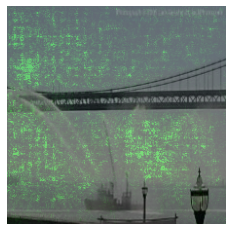

SmoothGrad with noise_amount 0.001


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 23.90it/s]


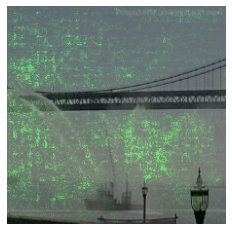

SmoothGrad with noise_amount 0.01


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 21.60it/s]


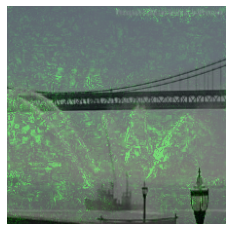

SmoothGrad with noise_amount 0.1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 23.74it/s]


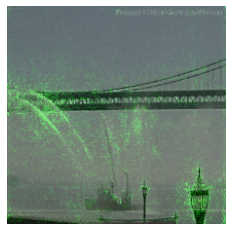

SmoothGrad with noise_amount 0.2


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 23.54it/s]


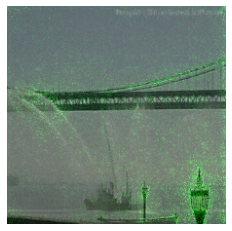

SmoothGrad with noise_amount 0.5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 21.88it/s]


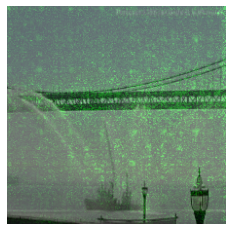

In [7]:
for noise_amount in [0.0, 0.001, 0.01, 0.1, 0.2, 0.5]:
    print("SmoothGrad with noise_amount", noise_amount)
    algo = it.SmoothGradInterpreter(paddle_model, device=device)
    gradients = algo.interpret(img_path, noise_amount=noise_amount, labels=None)

- When `noise_amount = 0.0`, it actually computes the vanilla gradient.
- When `noise_amount = 0.001`, the noise does not affect the gradient computation much. So the results are very similar to the vanilla gradient.
- When `noise_amount = 0.01`, it changes but there are still some noises.
- When `noise_amount = 0.1`, it produces the most intuitive results.
- When `noise_amount` becomes larger, noises again appear. It indicates that the noise added is too much.

So in general, `noise_amount = 0.1` is a default value that suits best for images. Too small or too large will reduce the explanation quality.

### n_samples

SmoothGrad with n_samples 1


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.67it/s]


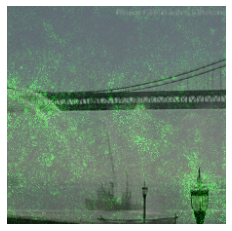

SmoothGrad with n_samples 5


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 24.05it/s]


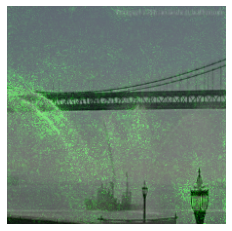

SmoothGrad with n_samples 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 23.21it/s]


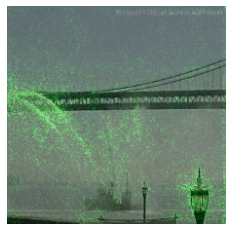

SmoothGrad with n_samples 50


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 23.69it/s]


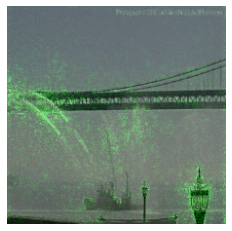

SmoothGrad with n_samples 100


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.16it/s]


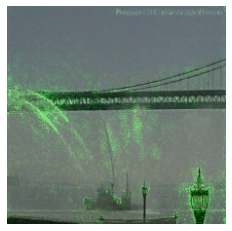

SmoothGrad with n_samples 500


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:21<00:00, 23.30it/s]


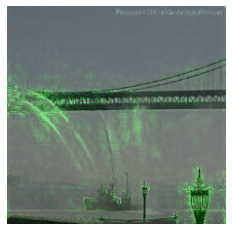

In [8]:

for n_samples in [1, 5, 10, 50, 100, 500]:
    print("SmoothGrad with n_samples", n_samples)
    algo = it.SmoothGradInterpreter(paddle_model, device=device)
    gradients = algo.interpret(img_path, n_samples=n_samples, labels=None)

- When `n_samples = 1` or `n_samples = 5`, the noises are not reduced by averaging the obtained gradients. 
- When `n_samples >= 50`, it's much better.

So setting `n_samples` to a larger value is better. However, the computation burden will linearly increase with the `n_samples` increasing. In general, the value between 50 and 100 is a good tradeoff between the explanation quality and the computation burden.

To end the `SmoothGrad`, let's see the results from different models and images.

### Other Models and Images

Loading pretrained mobilenet_v2.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 27.30it/s]


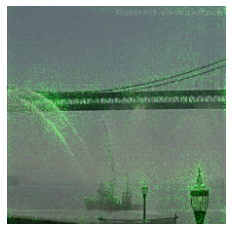

In [5]:
print("Loading pretrained mobilenet_v2.")
from paddle.vision.models import mobilenet_v2
paddle_model = mobilenet_v2(pretrained=True)

algo = it.SmoothGradInterpreter(paddle_model, device=device)
gradients = algo.interpret(img_path, labels=None)

Loading pretrained vgg16.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 41.80it/s]


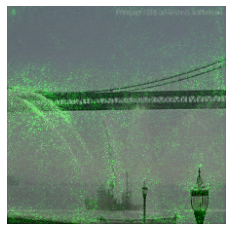

In [6]:
print("Loading pretrained vgg16.")
from paddle.vision.models import vgg16
paddle_model = vgg16(pretrained=True)

algo = it.SmoothGradInterpreter(paddle_model, device=device)
gradients = algo.interpret(img_path, labels=None)

Loading pretrained mobilenet_v2.
assets/catdog.png


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 41.96it/s]


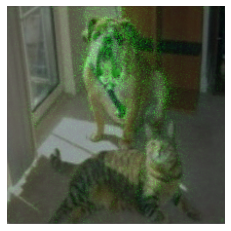

assets/deer.png


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 41.80it/s]


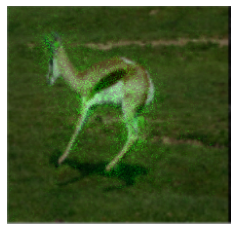

In [8]:
print("Loading pretrained mobilenet_v2.")

for img_path in ['assets/catdog.png', 'assets/deer.png']:
    print(img_path)
    algo = it.SmoothGradInterpreter(paddle_model, device=device)
    gradients = algo.interpret(img_path, labels=None)

## IntGrad

There are three important arguments `IntGrad`: `baselines`, `steps` and `num_random_trials`. 
```python
"""
    baselines (np.ndarray or None, optional): The baseline images to compare with. It should have the same shape as images and same length as the number of images. If None, the baselines of all zeros will be used. Default: ``None``.
    steps (int, optional): number of steps in the Riemann approximation of the integral. Default: ``50``.
    num_random_trials (int, optional): number of random initializations to take average in the end. Default: ``10``.
"""
```

- IntGrad considers all the data points between `baselines` and the input image. Usually `baselines` is set to zeros (`None`). While other choices like `random` or a given tensor are also acceptable.
- Since the integral $\text{IG}_c(x) = (x - x') \int_{\alpha=0}^{1} G_c(x'+\alpha (x-x')) d\alpha$ is intractable, so a Riemann approximation with `steps` $\text{IG}_c(x) = (x-x') \frac{1}{steps} \sum_{n=1}^{n=steps} G_c(x'+ \frac{n}{steps} (x-x'))$ is used for the numeric computation.
- `num_random_trials` is only used when `baselines = 'random'`. 

We show how each of them affects the explanation results.

### baselines

IntGrad with baselines random


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:17<00:00, 29.20it/s]


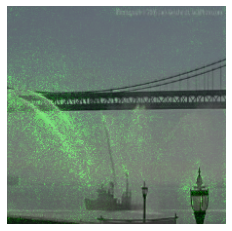

In [8]:
print("IntGrad with baselines random")
algo = it.IntGradCVInterpreter(paddle_model, device=device)
gradients = algo.interpret(img_path, baselines='random')

This setting usually works well, while the default setting is to use `None` as baselines, i.e., zeros.

IntGrad with baselines None


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 30.95it/s]


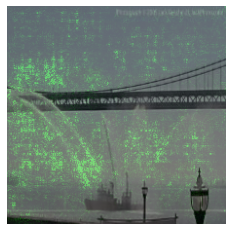

In [9]:
print("IntGrad with baselines None")
algo = it.IntGradCVInterpreter(paddle_model, device=device)
gradients = algo.interpret(img_path, baselines=None)

IntGrad with baselines customized baseline


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 30.18it/s]


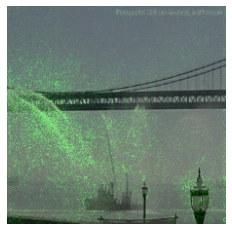

In [16]:
import numpy as np
print("IntGrad with baselines customized baseline")
img, data = it.data_processor.readers.images_transform_pipeline(img_path)
num_random_trials = 5
baselines = np.random.normal(size=(num_random_trials,) + data.shape).astype(np.array(data).dtype)

algo = it.IntGradCVInterpreter(paddle_model, device=device)
gradients = algo.interpret(img_path, baselines=baselines, num_random_trials=num_random_trials)

Note that, when using customized baseline, the first dimension must be equal to `num_random_trials`, and the data type has to be the same as `data`.

### steps

IntGrad with steps 2


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 25.12it/s]


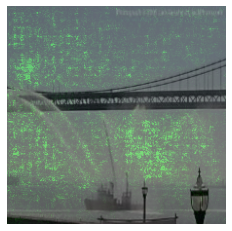

IntGrad with steps 5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 30.75it/s]


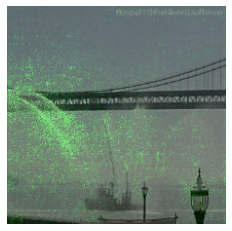

IntGrad with steps 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.97it/s]


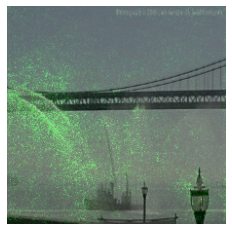

IntGrad with steps 50


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:05<00:00, 29.43it/s]


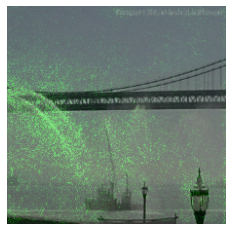

IntGrad with steps 100


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:10<00:00, 29.47it/s]


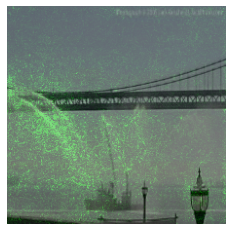

IntGrad with steps 500


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:49<00:00, 30.44it/s]


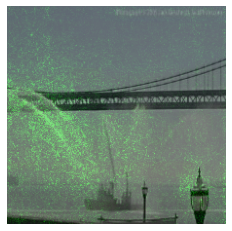

In [34]:

for steps in [2, 5, 10, 50, 100, 500]:
    print("IntGrad with steps", steps)
    algo = it.IntGradCVInterpreter(paddle_model, device=device)
    gradients = algo.interpret(img_path, baselines='random', num_random_trials=3, steps=steps)

As we can see, setting `steps` to a larger value is usually better until 100. However, the computation burden will linearly increase with the `steps` increasing. In general, the value between 50 and 100 is a good tradeoff between the explanation quality and the computation burden.

### num_random_trials

IntGrad with num_random_trials 1


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.66it/s]


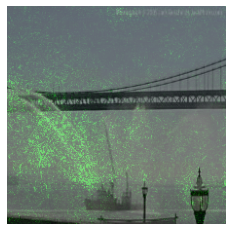

IntGrad with num_random_trials 2


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:07<00:00, 26.38it/s]


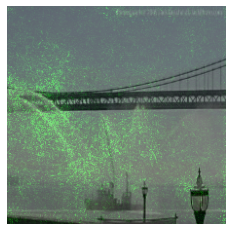

IntGrad with num_random_trials 5


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:19<00:00, 25.15it/s]


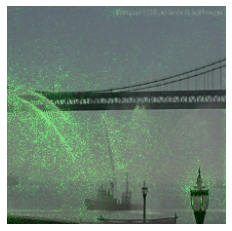

IntGrad with num_random_trials 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:38<00:00, 25.66it/s]


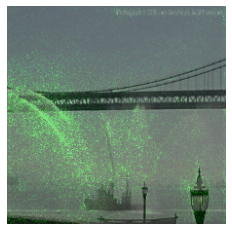

IntGrad with num_random_trials 20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:16<00:00, 26.13it/s]


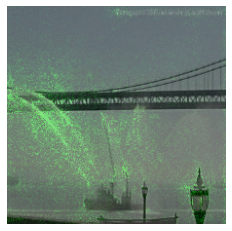

In [35]:
for num_random_trials in [1, 2, 5, 10, 20]:
    print("IntGrad with num_random_trials", num_random_trials)
    algo = it.IntGradCVInterpreter(paddle_model, device=device)
    gradients = algo.interpret(img_path, baselines='random', num_random_trials=num_random_trials, steps=100)

It's better to set `num_random_trials` larger, however it will be multiplied by `steps` to have a large number of gradient computation. So it's tricky to choose a good combination between them to have a good explanation. The default value is 10 with `steps` being 50.

More choices of these three arguments can be tuned further.

### More models and More images

Loading pretrained mobilenet_v2.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:15<00:00, 33.17it/s]


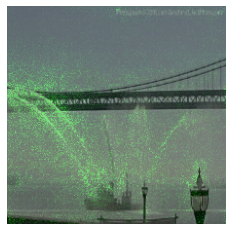

In [36]:
print("Loading pretrained mobilenet_v2.")
from paddle.vision.models import mobilenet_v2
paddle_model = mobilenet_v2(pretrained=True)

algo = it.IntGradCVInterpreter(paddle_model, device=device)
gradients = algo.interpret(img_path, baselines='random')

Loading pretrained vgg16.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:07<00:00, 62.97it/s]


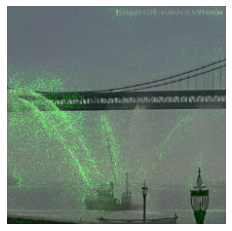

In [37]:
print("Loading pretrained vgg16.")
from paddle.vision.models import vgg16
paddle_model = vgg16(pretrained=True)

algo = it.IntGradCVInterpreter(paddle_model, device=device)
gradients = algo.interpret(img_path, baselines='random')

Loading pretrained mobilenet_v2.
assets/catdog.png


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 62.98it/s]


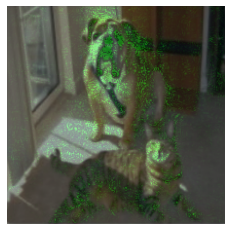

assets/deer.png


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 63.17it/s]


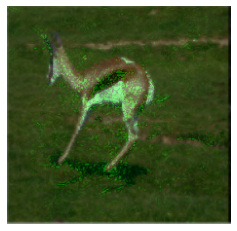

In [39]:
print("Loading pretrained mobilenet_v2.")

for img_path in ['assets/catdog.png', 'assets/deer.png']:
    print(img_path)
    algo = it.IntGradCVInterpreter(paddle_model, device=device)
    gradients = algo.interpret(img_path)

## Next Step



To deepen your understanding, check out the papers [SmoothGrad: Removing Noise by Adding Noise
](https://arxiv.org/abs/1706.03825) and [Axiomatic Attribution for Deep Networks](https://arxiv.org/abs/1703.01365).

Note that input gradient based Interpreters can be applied to any differentiable models and any tasks, not limited in visual recognition. We have also the tutorials of NLP tasks, using 
[Ernie2.0 in English](https://github.com/PaddlePaddle/InterpretDL/blob/master/tutorials/ernie-2.0-en-sst-2.ipynb) ([on NBViewer](https://nbviewer.org/github/PaddlePaddle/InterpretDL/blob/master/tutorials/ernie-2.0-en-sst-2.ipynb)), 
[Bert in English](https://github.com/PaddlePaddle/InterpretDL/blob/master/tutorials/bert-en-sst-2.ipynb) ([on NBViewer](https://nbviewer.org/github/PaddlePaddle/InterpretDL/blob/master/tutorials/bert-en-sst-2.ipynb)), 
[BiLSTM in Chinese](https://github.com/PaddlePaddle/InterpretDL/blob/master/tutorials/bilstm-zh-chnsenticorp.ipynb) ([on NBViewer](https://nbviewer.org/github/PaddlePaddle/InterpretDL/blob/master/tutorials/bilstm-zh-chnsenticorp.ipynb)) and 
[Ernie1.0 in Chinese](https://github.com/PaddlePaddle/InterpretDL/blob/master/tutorials/ernie-1.0-zh-chnsenticorp.ipynb) ([on NBViewer](https://nbviewer.org/github/PaddlePaddle/InterpretDL/blob/master/tutorials/ernie-1.0-zh-chnsenticorp.ipynb)) as examples. For text visualizations, NBViewer gives better and colorful rendering results. In NLP tutorials, `IntGrad` and `GradSHAP` are presented too.